In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
from cesium import datasets

eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


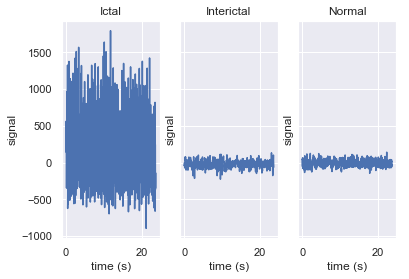

In [3]:
# Group together classes (Z, O), (N, F), (S) as normal, interictal, ictal
eeg["classes"] = eeg["classes"].astype("U16") #  allocate memory for longer class names
eeg["classes"][np.logical_or(eeg["classes"]=="Z", eeg["classes"]=="O")] = "Normal"
eeg["classes"][np.logical_or(eeg["classes"]=="N", eeg["classes"]=="F")] = "Interictal"
eeg["classes"][eeg["classes"]=="S"] = "Ictal"

fig, ax = plt.subplots(1, len(np.unique(eeg["classes"])), sharey=True)
for label, subplot in zip(np.unique(eeg["classes"]), ax):
    i = np.where(eeg["classes"] == label)[0][0]
    subplot.plot(eeg["times"][i], eeg["measurements"][i])
    subplot.set(xlabel="time (s)", ylabel="signal", title=label)

# Featurization

In [4]:
from cesium import featurize
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]
fset_cesium = featurize.featurize_time_series(times=eeg["times"],
                                              values=eeg["measurements"],
                                              errors=None,
                                              features_to_use=features_to_use)
fset_cesium.head()

feature amplitude percent_beyond_1_std maximum     max_slope median  \
channel         0                    0       0             0      0   
0           143.5             0.327313   141.0  11107.796610   -4.0   
1           211.5             0.290212   169.0  20653.559322  -51.0   
2           165.0             0.302660   184.0  13537.627119   13.0   
3           171.5             0.300952   162.0  17008.813559   -4.0   
4           170.0             0.305101   152.0  13016.949153  -18.0   

feature median_absolute_deviation percent_close_to_median minimum      skew  \
channel                         0                       0       0         0   
0                            28.0                0.505004  -146.0  0.032805   
1                            32.0                0.640469  -254.0 -0.092715   
2                            31.0                0.515987  -146.0 -0.004100   
3                            31.0                0.541128  -181.0  0.063678   
4                            29.0                0.566268  -188.0  0.142753   

feature        std weighted_average  
channel          0                0  
0        40.411000        -4.132048  
1        48.812668       -52.444716  
2        47.144789        12.705150  
3        47.072316        -3.992433  
4        44.910958       -17.999268

# Custom feature functions

In [5]:
import numpy as np
import scipy.stats

def mean_signal(t, m, e):
    return np.mean(m)

def std_signal(t, m, e):
    return np.std(m)

def mean_square_signal(t, m, e):
    return np.mean(m ** 2)

def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))

def skew_signal(t, m, e):
    return scipy.stats.skew(m)

In [6]:
guo_features = {
    "mean": mean_signal,
    "std": std_signal,
    "mean2": mean_square_signal,
    "abs_diffs": abs_diffs_signal,
    "skew": skew_signal
}

import pywt

n_channels = 5
eeg["dwts"] = [pywt.wavedec(m, pywt.Wavelet("db1"), level=n_channels-1)
               for m in eeg["measurements"]]
fset_dwt = featurize.featurize_time_series(times=None, values=eeg["dwts"], errors=None,
                                           features_to_use=list(guo_features.keys()),
                                           custom_functions=guo_features)
fset_dwt.head()

feature        mean                                                 std  \
channel           0         1         2         3         4           0   
0        -17.080739 -6.067121 -0.979336  0.154634  0.035545  112.473774   
1       -210.210117 -3.743191  0.511377  0.057561 -0.024847  119.836067   
2         51.831712  0.714981  0.247418 -0.101951  0.007937  134.809626   
3        -15.429961  9.348249 -0.099243 -0.228293  0.181522  104.420503   
4        -71.982490 -3.787938 -0.183324 -0.034146 -0.048314  124.012203   

feature                                                ...    abs_diffs  \
channel          1          2          3          4    ...            0   
0        72.970862  48.167301  25.774846  10.154899    ...     25127.00   
1        92.777487  67.005780  33.957464  13.673398    ...     28742.00   
2        78.294247  60.275759  28.088980  11.246134    ...     28284.75   
3        89.999242  67.249397  35.929621  16.366747    ...     24848.25   
4        73.870175  59.986686  27.599723  11.655378    ...     23848.25   

feature                                                     skew            \
channel         1             2        3             4         0         1   
0        18056.00  32408.117995  34239.0  19883.842687 -0.043301  0.065784   
1        25226.00  44392.163723  45330.5  26138.909273 -0.286254 -0.016437   
2        19826.25  42874.712570  36283.0  21020.163284  0.042923 -0.121195   
3        25715.25  43004.466665  47952.0  34686.416044  0.177416  0.214529   
4        18328.75  39809.051121  35455.5  22640.144920  0.220502 -0.077603   

feature                                
channel         2         3         4  
0        0.299892  0.123948  0.117937  
1        0.168179 -0.005521  0.187815  
2       -0.254241 -0.061304 -0.136422  
3       -0.013705 -0.007339  0.013836  
4        0.285906  0.087555  0.066677  

[5 rows x 25 columns]

# Model building

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

train, test = train_test_split(np.arange(len(eeg["classes"])), random_state=0)

model_cesium = RandomForestClassifier(n_estimators=128, max_features="auto",
                                      random_state=0)
model_cesium.fit(fset_cesium.iloc[train], eeg["classes"][train])

model_dwt = KNeighborsClassifier(3)
model_dwt.fit(fset_dwt.iloc[train], eeg["classes"][train])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

# Prediction

In [8]:
from sklearn.metrics import accuracy_score

preds_cesium = model_cesium.predict(fset_cesium)
preds_dwt = model_dwt.predict(fset_dwt)

print("Built-in cesium features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_cesium[train], eeg["classes"][train]),
          accuracy_score(preds_cesium[test], eeg["classes"][test])))
print("Wavelet transform features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_dwt[train], eeg["classes"][train]),
          accuracy_score(preds_dwt[test], eeg["classes"][test])))

Built-in cesium features: training accuracy=100.00%, test accuracy=83.20%
Wavelet transform features: training accuracy=97.87%, test accuracy=95.20%
